_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         204928    
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.693082, acc: 0.500000] [adversarial loss: 0.817380, acc: 0.000000]
100: [discriminator loss: 0.379071, acc: 0.890625] [adversarial loss: 0.877807, acc: 0.234375]
200: [discriminator loss: 0.571595, acc: 0.640625] [adversarial loss: 0.739669, acc: 0.468750]
300: [discriminator loss: 0.586802, acc: 0.671875] [adversarial loss: 0.762078, acc: 0.375000]
400: [discriminator loss: 0.556203, acc: 0.750000] [adversarial loss: 0.667418, acc: 0.609375]
500: [discriminator loss: 0.472554, acc: 0.726562] [adversarial loss: 0.990486, acc: 0.140625]
600: [discriminator loss: 0.437225, acc: 0.812500] [adversarial loss: 1.092331, acc: 0.171875]
700: [discriminator loss: 0.463672, acc: 0.804688] [adversarial loss: 0.847457, acc: 0.406250]
800: [discriminator loss: 0.557779, acc: 0.718750] [adversarial loss: 2.036735, acc: 0.000000]
900: [discriminator loss: 0.521907, acc: 0.750000] [adversarial loss: 0.822947, acc: 0.437500]
1000: [discriminator loss: 0.577516, acc: 0.742188] 

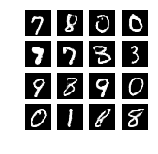

In [ ]:
'''Trains DCGAN on MNIST using Keras

DCGAN is a Generative Adversarial Network (GAN) using CNN.
The generator tries to fool the discriminator by generating fake images.
The discriminator learns to discriminate real from fake images.
The generator + discriminator form an adversarial network.
DCGAN trains the discriminator and adversarial networks alternately.
During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the adversarial on how
to improve its ability to generate fake images.

[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse


def build_generator(inputs, image_size):
    """Build a Generator Model

    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.

    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)

    # Returns
        Model: Generator Model
    """

    image_resize = image_size // 4
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator


def build_discriminator(inputs):
    """Build a Discriminator Model

    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.

    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)

    # Returns
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator


def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.

    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    # the GAN models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        if (i%100==0):
          print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")


def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models():
    # load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    # build adversarial model
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)


def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")



build_and_train_models()
